In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
import pickle

import config
import statsmodels
import features

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, f_regression, mutual_info_regression

In [2]:
def load_features(problem, include_mzn2feat=True):
    X, y = features.cached_feature_matrix(problem, include_opt=True, include_mzn2feat=include_mzn2feat)
    y = y['optimum']
    X_names = features.feature_names(p, include_mzn2feat=include_mzn2feat)
    assert X.shape[1] == X_names.shape[0], "Problem {}: Feature vectors don't match ({}, {})".format(p.name, X.shape, X_names.shape)
    return X, y, X_names

p = config.PROBLEMS[0]
X, y, X_names = load_features(p)
print("Problem", p.name, X.shape, X_names.shape)
print(X_names)

Problem tsp (10000, 107) (107,)
['len/coords' 'mean/coords' 'median/coords' 'std/coords' 'iqr/coords'
 'min/coords' 'max/coords' 'skew/coords' 'kurtosis/coords' 'number/n'
 'c_avg_deg_cons' 'c_avg_dom_cons' 'c_avg_domdeg_cons' 'c_bounds_d'
 'c_bounds_r' 'c_bounds_z' 'c_cv_deg_cons' 'c_cv_dom_cons'
 'c_cv_domdeg_cons' 'c_domain' 'c_ent_deg_cons' 'c_ent_dom_cons'
 'c_ent_domdeg_cons' 'c_logprod_deg_cons' 'c_logprod_dom_cons'
 'c_max_deg_cons' 'c_max_dom_cons' 'c_max_domdeg_cons' 'c_min_deg_cons'
 'c_min_dom_cons' 'c_min_domdeg_cons' 'c_num_cons' 'c_priority'
 'c_ratio_cons' 'c_sum_ari_cons' 'c_sum_dom_cons' 'c_sum_domdeg_cons'
 'd_array_cons' 'd_bool_cons' 'd_bool_vars' 'd_float_cons' 'd_float_vars'
 'd_int_cons' 'd_int_vars' 'd_ratio_array_cons' 'd_ratio_bool_cons'
 'd_ratio_bool_vars' 'd_ratio_float_cons' 'd_ratio_float_vars'
 'd_ratio_int_cons' 'd_ratio_int_vars' 'd_ratio_set_cons'
 'd_ratio_set_vars' 'd_set_cons' 'd_set_vars' 'gc_diff_globs'
 'gc_global_cons' 'gc_ratio_diff' 'gc_rati

In [3]:
print(y.head())

dzn
tsp05292.dzn    10276
tsp00896.dzn     9269
tsp08757.dzn     8758
tsp08890.dzn     6630
tsp09266.dzn     7465
Name: optimum, dtype: int64


In [14]:
pearsonvals = []
for i in range(X.shape[1]):
    pears, pval = pearsonr(X[:, i], y.values)
    pearsonvals.append((X_names[i], pears, pval))
    
pearsonvals.sort(key=lambda x: (x[3] >= 1, -abs(x[2]), -x[3]))

for r in pearsonvals:
    print(*r)

c_cv_dom_cons 0.992123747098902 0.0
c_cv_deg_cons 0.9920883342457121 0.0
c_max_domdeg_cons 0.9864483715862971 0.0
c_max_dom_cons 0.9839704986064263 0.0
v_avg_deg_vars 0.9836645013492654 0.0
len/coords 0.9836617117943005 0.0
number/n 0.9836617117943005 0.0
c_max_deg_cons 0.9836617117943005 0.0
d_array_cons 0.9836617117943005 0.0
d_bool_cons 0.9836617117943005 0.0
d_bool_vars 0.9836617117943005 0.0
d_int_vars 0.9836617117943005 0.0
v_def_vars 0.9836617117943005 0.0
v_intro_vars 0.9836617117943005 0.0
v_max_deg_vars 0.9836617117943005 0.0
v_num_aliases 0.9836617117943005 0.0
v_num_vars 0.9836617117943005 0.0
kurtosis/coords -0.9836545368214584 0.0
c_ratio_cons 0.9836402490188482 0.0
v_ratio_bounded 0.9835527192180914 0.0
max/coords 0.981411902137129 0.0
c_avg_domdeg_cons 0.9813158178048318 0.0
mean/coords 0.9803809746620301 0.0
median/coords 0.9803809746620301 0.0
c_avg_dom_cons 0.9803006523342351 0.0
v_logprod_deg_vars 0.9802692810140753 0.0
o_dom 0.9792885601087513 0.0
o_dom_deg 0.97928

/home/helge/anaconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


## F-Regression for a single problem

Univariate linear regression tests. Tests the linearity between each feature and the regression target.
A higher value shows a higher correlation (-Log(p_value)).

http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression

http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html#sklearn.feature_selection.mutual_info_regression

/home/helge/anaconda3/envs/py3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


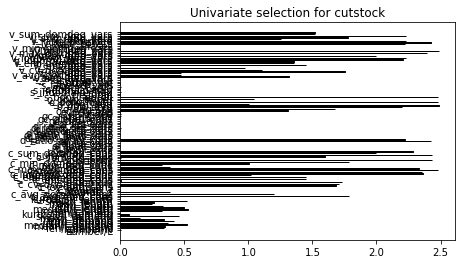

In [5]:
def univariate_statistics(X, y):
    f_test, _ = f_regression(X, y, center=True)
    f_test /= np.max(f_test)

    mi = mutual_info_regression(X, y)
    mi /= np.max(mi)
    
    return f_test, mi

mi = mutual_info_regression(X, y)

X_indices = np.arange(X.shape[-1])
plt.barh(X_indices, mi, height=.2, tick_label=X_names,
        label=r'Mutual Information', color='black',
        edgecolor='black')
#plt.barh(X_indices - .2, f_test, height=.2,
#        label=r'F-Test', color='darkorange',
#        edgecolor='black')
plt.title('Univariate selection for {}'.format(p.name))
plt.show()

In [6]:
def top_feature_idx(statistic, number=3):
    return statistic.argsort()[-number:]    

def top_feature_names(statistic, X_names, number=3):
    top_feat = top_feature_idx(statistic, number)
    top_feat_names = X_names[top_feat]
    return top_feat_names

## Analysis over all problems

We are interested to see which features are most useful over multiple problems and what information of each problem does deliver the most value to the regression task.
In this analysis, we take two perspectives: We summarize the list features regardless of the variables, and we look at each variable.

To score the relevance, we rely again on the F-test estimate as above.

TypeError: unsupported operand type(s) for +: 'int' and 'str'

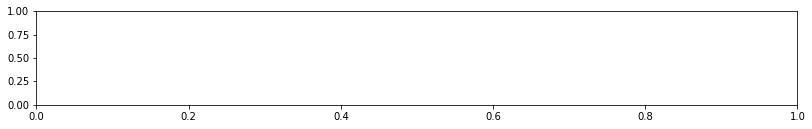

In [7]:
fig = plt.figure(figsize=(30, 10))

for idx, p in enumerate(config.PROBLEMS, start=1):
    ax = fig.add_subplot(5, 2, idx)
    X, y, X_names = load_features(p)
    
    #mi = mutual_info_regression(X, y)
    #mi /= mi.max() # Scale to [0, 1]
    
    mi = -np.log10([pearsonr(X[:, i], y)[1] for i in range(X.shape[1])])
    
    X_indices = np.arange(X.shape[-1])
    ax.barh(X_indices, mi, height=.2, tick_label=X_names,
            label=r'Mutual Information', color='black',
            edgecolor='black', align='center')
    ax.set_title('Univariate selection for {}'.format(p.name))
    
plt.tight_layout()
plt.savefig('univariate_log_p.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
# Top 5 features + Mutual Information Values (descending order)
top5data = []
featlist = []

for p in config.PROBLEMS:
    X, y, X_names = load_features(p)
    print(p.name, X.shape, y.shape)
    #f_test, mi = univariate_statistics(X, y)
    mi = mutual_info_regression(X, y)
    #pvals = [pearsonr(X[:, i], y)[1] for i in mi.argsort()[:5]]
    #print(p.name, top_feature_names(f_test, X_names), top_feature_names(mi, X_names))
    top5data.append([p.name] + top_feature_names(mi, X_names, number=5).tolist()[::-1] + sorted(mi, reverse=True)[:5])
    
    featlist.extend([(p.name, Xn.split('/')[0], miv) for Xn, miv in zip(X_names, mi)])

top5df = pd.DataFrame(top5data)
featdf = pd.DataFrame(featlist, columns=['problem', 'feature', 'mi'])

tsp (10000, 107) (10000,)


/home/helge/anaconda3/envs/py3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


mrcpsp (11182, 154) (11182,)


/home/helge/anaconda3/envs/py3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


AssertionError: Problem rcpsp: Feature vectors don't match ((2904, 98), (135,))

In [21]:
cm = sns.light_palette("green", as_cmap=True)
pd.pivot_table(featdf, index='problem', columns='feature', aggfunc='max', margins=True).style.highlight_max(axis=1)

In [17]:
top5df.loc[:, 0:5]

,0,1,2,3,4,5
0,tsp,number/n,len/c,max/c,min/c,iqr/c
1,mrcpsp,len/dur,max/modes,number/n_opt,mean/modes,len/rreq
2,rcpsp,len/d,number/n_tasks,len/rr,min/suc,median/suc
3,2DBinPacking,len/ItemHeight,number/N,len/ItemWidth,number/W,number/H
4,prize-collecting,number/n,skew/p,kurtosis/p,len/p,std/p
5,jobshop,len/job_task_machine,len/job_task_duration,number/n_jobs,std/job_task_machine,median/job_task_machine
6,vrp,len/Distance,len/Demand,number/N,max/Distance,std/Distance
7,open_stacks,number/c,len/orders,max/orders,std/orders,mean/orders
8,table-layout,number/rows,number/maxconfig,std/height,len/height,len/width
9,depot-placement,median/AllDist,mean/AllDist,iqr/AllDist,std/AllDist,max/AllDist


In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR

for p in config.PROBLEMS:
    print(p.name)
    X, y, X_names = load_features(p)
    
    if X.shape[0] > 500:
        sel = sorted(np.random.choice(np.arange(0, X.shape[0]), 500, replace=False))
        X = X[sel, :]
        y = y[sel]
    
    estimator = SVR(kernel="linear")
    selector = RFECV(estimator, step=1, cv=5, n_jobs=4)
    selector = selector.fit(X, y)    
    print(selector.support_)
    print(selector.ranking_)

tsp
[ True False False False  True  True  True False  True  True]
[1 2 4 3 1 1 1 5 1 1]
mrcpsp
[False  True  True  True  True  True False  True  True  True False False
  True  True  True  True False  True  True  True  True  True  True  True
 False  True  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True False  True  True  True
  True  True  True  True  True  True  True  True  True]
[2 1 1 1 1 1 6 1 1 1 3 4 1 1 1 1 9 1 1 1 1 1 1 1 7 1 1 1 1 1 5 1 1 1 1 1 1
 1 1 1 1 1 1 1 8 1 1 1 1 1 1 1 1 1 1 1 1]
rcpsp
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1]
2DBinPacking
[False False False False False False False False False False False False
 False False False False False  True

In [7]:
# We plot each feature against the optimum to get a visual understanding of the distribution
for p in config.PROBLEMS:
    X, y, X_names = load_features(p, include_mzn2feat=False)

    pearsonvals = []
    for i in range(X.shape[1]):
        pears, pval = pearsonr(X[:, i], y.values)
        pearsonvals.append((i, X_names[i], np.round(pears, 3), pval))
    
    #pearsonvals.sort(key=lambda x: (x[3] >= 1, -abs(x[2]), -x[3]))
        
    f_scores, pvals = f_regression(X, y.values)
    #f_scores /= np.max(f_scores)
    
    fvals = []
    for i in range(X.shape[1]):
        fscore, pval = f_scores[i], pvals[i]
        fvals.append((i, X_names[i], np.round(fscore, 3), pval))
    
    fvals.sort(key=lambda x: (x[3] >= 1, -abs(x[2]), -x[3]))
    
    fig, axes = plt.subplots(nrows=len(X_names), ncols=1, figsize=(5, 1*len(fvals)))
    
    #plt.figure()

    for ax, (i, featname, fscore, pval) in zip(axes, fvals):
        ax.scatter(X[:, i], y, s=0.5)
        ax.set_title("{} - {} (F: {:.3f}, Pears: {:.2f}, p: {:.2f})".format(p.name, featname, fscore, pearsonvals[i][2], pval))
    
    #plt.show()
    #fig.savefig('plots/{}_{}.png'.format(p.name, featname.replace('/', '-')), dpi=300)
    plt.tight_layout()
    plt.savefig('plots/{}_smallfeat.png'.format(p.name, featname.replace('/', '-')), dpi=200, bbox_inches='tight')
    plt.close()


/home/helge/anaconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/home/helge/anaconda3/envs/py3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/helge/anaconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/helge/anaconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/helge/anaconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/home/helge/anaconda3/envs/py3/lib/python3.6/site-packages/sklearn/feature_s

In [8]:
df = pd.DataFrame(X, columns=X_names)
df["optimum"] = y.values
#df.head()
sns.relplot(x="len/coords", y="optimum", data=df)

ValueError: Could not interpret input 'len/coords'